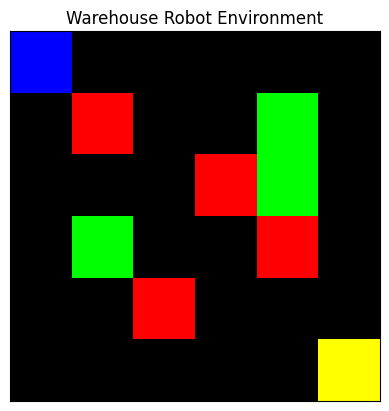

Step 1: State (0, 0, 0), Action 2, Reward -1, Total Reward -1


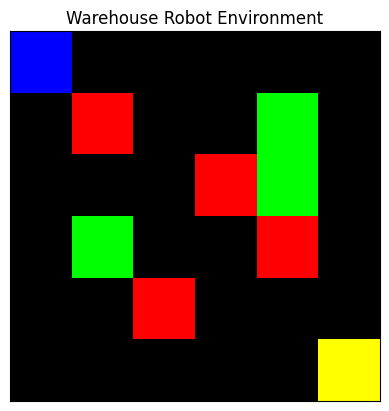

Step 2: State (0, 1, 0), Action 3, Reward -1, Total Reward -2


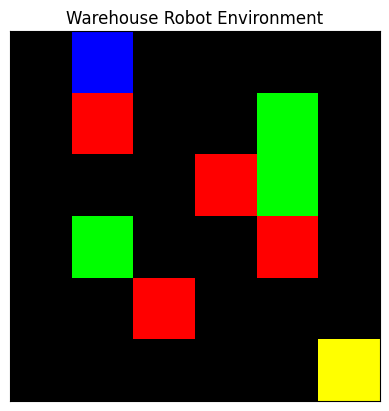

Step 3: State (0, 1, 0), Action 0, Reward -1, Total Reward -3


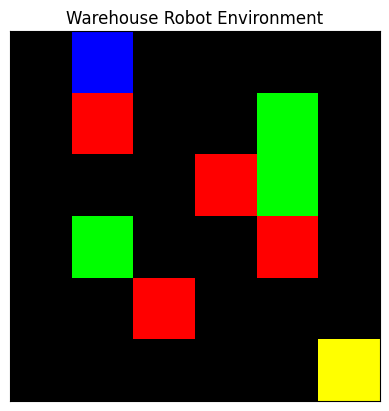

Step 4: State (0, 1, 0), Action 0, Reward -1, Total Reward -4


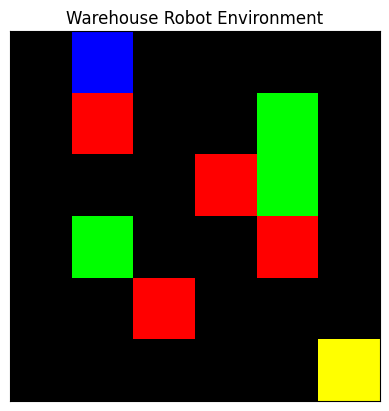

Step 5: State (0, 0, 0), Action 2, Reward -1, Total Reward -5


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random

class WarehouseRobotEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, stochastic=False):
        super(WarehouseRobotEnv, self).__init__()
        self.grid_size = 6
        self.action_space = spaces.Discrete(6)  # Actions: Up, Down, Left, Right, Pick-up, Drop-off
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])  # (x, y, carrying)

        self.stochastic = stochastic
        self.reset()

    def reset(self):
        """Reset the environment at the start of each episode."""
        self.agent_pos = [0, 0]
        self.obstacles = [[1, 1], [2, 3], [4, 2], [3, 4]]  # Define obstacles first
        self.dropoff_pos = (5, 5)  # Define drop-off location before calling _random_position()
        self.pickup_positions = [self._random_position() for _ in range(3)]  # 3 random pickup locations

        self.carrying = 0  # Carrying 0 or 1 item at a time
        self.total_items = len(self.pickup_positions)  # Total items to pick up and drop off
        self.timesteps = 0

        return self._get_observation()
    
    def _random_position(self):
        """Generates a random position avoiding obstacles, drop-off, and agent start."""
        while True:
            pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            if pos != self.agent_pos and pos not in self.obstacles and pos != list(self.dropoff_pos):
                return pos

    def _get_observation(self):
        """Returns the agent's current state: (x, y, carrying)."""
        return (self.agent_pos[0], self.agent_pos[1], self.carrying)
    
    def step(self, action):
        """Updates the environment based on the action taken."""
        if self.stochastic and random.random() < 0.2:
            action = random.choice([0, 1, 2, 3])  # 20% chance of random movement

        new_pos = self.agent_pos[:]
        if action == 0:  # Up
            new_pos[0] -= 1
        elif action == 1:  # Down
            new_pos[0] += 1
        elif action == 2:  # Left
            new_pos[1] -= 1
        elif action == 3:  # Right
            new_pos[1] += 1
        
        reward = -1  # Default movement penalty

        # If moving into an obstacle
        if new_pos in self.obstacles:
            reward = -20  # Obstacle penalty
        elif 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            self.agent_pos = new_pos  # Move if within bounds

        # Pick-up Logic
        if action == 4 and self.agent_pos in self.pickup_positions and self.carrying == 0:
            self.carrying = 1
            self.pickup_positions.remove(self.agent_pos)  # Remove picked location
            reward = 25
        
        # Drop-off Logic
        elif action == 5 and self.agent_pos == list(self.dropoff_pos) and self.carrying == 1:
            self.carrying = 0  # Drop the item
            self.total_items -= 1
            reward = 100

        # Check if the episode ends
        done = self.total_items == 0 or self.timesteps >= 50
        self.timesteps += 1

        return self._get_observation(), reward, done, {}

    def render(self):
        """Visualize the warehouse grid."""
        grid = np.zeros((self.grid_size, self.grid_size, 3))
        grid[tuple(self.agent_pos)] = [0, 0, 1]  # Agent (Blue)
        for pickup in self.pickup_positions:
            grid[tuple(pickup)] = [0, 1, 0]  # Pick-up locations (Green)
        grid[self.dropoff_pos] = [1, 1, 0]  # Drop-off point (Yellow)
        for obs in self.obstacles:
            grid[tuple(obs)] = [1, 0, 0]  # Obstacles (Red)
        
        plt.imshow(grid)
        plt.title("Warehouse Robot Environment")
        plt.xticks([])
        plt.yticks([])
        plt.show()

# Main function to test environment
def main():
    env = WarehouseRobotEnv(stochastic=False)  # Change to True for stochastic behavior
    total_reward = 0

    for step in range(5):
        env.render()
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        print(f"Step {step + 1}: State {obs}, Action {action}, Reward {reward}, Total Reward {total_reward}")
        
        if done:
            print("Episode Ended.")
            break

if __name__ == "__main__":
    main()
